In [3]:
import pandas as ps
import rasterio
from rasterio.transform import from_bounds
from rasterio.plot import show
import fiona
import shapefile
import os, sys, csv, re
import shapely.geometry

import numpy as np
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

In [4]:
# base_dir = r"D:\Acadamics\University\Year_3\Sem_2\GIS3005 - Remote Sensing\Assignment\1"
base_dir = os.getcwd()
tiff_dataset = os.path.join(base_dir, r"NTLE")
gdp_dataset_filtered = os.path.join(base_dir, r"GDP\API_NY.GDP.MKTP.CD_DS2_en_csv_v2_4770391_filtered.csv")
countries_dataset = os.path.join(base_dir, r"countries")
output_folder = os.path.join(base_dir, r"output")
countries_interested = ["PAK", "NPL", "LKA", "IND", "BTN", "BGD"]
nightlight_dataset = {}

In [5]:
class progress():
    def __init__(self, current, maximum):
        self.current = current
        self.maximum = maximum
        self.BAR_WIDTH = 40
        
        self.current -=1
        self.next()
        
        
    def next(self):
        self.current += 1
        x = int(self.BAR_WIDTH*self.current/self.maximum)
        y = round(self.current/self.maximum*100, 1)
        text_pb = "{}[{}{}] {}/{} {}%".format("Processing", "#"*x, "."*(self.BAR_WIDTH-x), self.current, self.maximum, y)
        print(text_pb, end='\r', file=sys.stdout, flush=True)

In [6]:
def get_files(path, extention=".tif", regex=""):
    files = []
    for file in os.listdir(path):
        if file.endswith(extention):
            if regex != "":
                if not re.match(regex, file): continue
            temp_path = os.path.join(path, file)
            if os.path.exists(temp_path):
                files.append(temp_path)
    return files

In [7]:
def clip(raster, geometry):
    out_image, out_transform = rasterio.mask.mask(raster, geometry, crop=True, nodata=0)
    return out_image

In [8]:
def get_geometry(shapefile):
    with fiona.open(shapefile, "r") as shapefile:
        return [feature["geometry"] for feature in shapefile]

In [9]:
def get_attribute(shp, field):
    sf = shapefile.Reader(shp)
    fields = sf.fields[1:]  # exclude the first 'DeletionFlag' field
    records = sf.records()
    
    index = 0
    for item in fields:
        if item[0] == field:
            break
        index += 1
    
    return records[0][index]

In [10]:
def save(full_path, ndarray):
    
    path_, file_ = os.path.split(full_path)
    
    if not os.path.exists(path_):
        os.mkdir(path_)
    if os.path.isfile(full_path):
        os.remove(full_path)
        
    np.save(full_path, ndarray)

In [11]:
def save_tiff(out_image, ndarray, metadata):
    
    with rasterio.open(fp=out_image, mode='w',**metadata) as dst:
             dst.write(ndarray)

In [12]:
def load(npy_file, band=None):
    if os.path.isfile(npy_file):
        if band == None: return np.load(npy_file)
        return np.load(npy_file)[band]
    return None

In [13]:
def rescale(tiff_obj_arr):
    for file in tiff_obj_arr:
        pass

In [14]:
def predict(train_x, train_y, test_x, test_y):

    # # Normalize the input data
    # train_x = (train_x.reshape(-1, 1)[:,1:] - np.mean(train_x.reshape(-1, 1)[:,1:], axis=0)) / np.std(train_x.reshape(-1, 1)[:,1:], axis=0)
    # test_x = (test_x.reshape(-1, 1)[:,1:] - np.mean(test_x.reshape(-1, 1)[:,1:], axis=0)) / np.std(test_x.reshape(-1, 1)[:,1:], axis=0)

    # model = tf.keras.Sequential()
    # model.compile(optimizer='sgd', loss='mean_squared_error')
    # model.fit(train_x, train_y, epochs=500)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(train_x.reshape(-1, 1))
    y_scaled = scaler.fit_transform(train_y.reshape(-1, 1))

    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2)

    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    # Train the model
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val))

    # Evaluate the model
    model.evaluate(X_val, y_val)

    # Make predictions
    new_X_scaled = scaler.transform(test_x.reshape(-1, 1))
    predictions = model.predict(new_X_scaled)
    
    return predictions

In [37]:
year_start = 1992
year_end = 2013
test_for_year = 4
ISO = countries_interested[4]

In [38]:
# Load saved npy - RAM out of space!
nightlight_dataset = []
pbar = progress(0, len(get_files(output_folder, '.npy')))
for npy in get_files(output_folder, '.npy'):
    file_name = os.path.splitext(os.path.split(npy)[1])[0]
    iso, year = file_name.split("_")
    
    if iso in ["Pakistan", "Nepal", "Sri Lanka", "India", "Bhutan", "Bangladesh"]:
        index = ["Pakistan", "Nepal", "Sri Lanka", "India", "Bhutan", "Bangladesh"].index(iso)
        iso = ["PAK", "NPL", "LKA", "IND", "BTN", "BGD"][index]
    
    pbar.next()
    
    if int(year) > year_end:
        continue
    elif int(year) < year_start:
        continue
        
    # if ISO != None:
    #     if iso != ISO:
    #         continue
    
    # if iso in nightlight_dataset:
    #     nightlight_dataset[iso].append(load(npy))
    # else:
    #     nightlight_dataset[iso] = [load(npy).mean(),]
        
    # nightlight_dataset.append([iso, year, load(npy, 'cf_cvg').mean()]) # For VIIRS
    nightlight_dataset.append([iso, year, load(npy).mean()]) # For CCNL



In [39]:
gdp_df = ps.read_csv(gdp_dataset_filtered, skiprows=0)
nightlight_df = ps.DataFrame(data=nightlight_dataset, columns=["Code", "Year", "NightLight"])
nightlight_df["Year"] = nightlight_df["Year"].astype('int64')
nightlight_df["NightLight"] = nightlight_df["NightLight"].astype('float64')
# filter_ = df['Code'] != ISO
# df = df.drop(df[filter_].index, inplace=False)


print(gdp_df.head(1))
print(nightlight_df.head(1))

gdp_nightlight = ps.merge(gdp_df, nightlight_df, on=["Code", "Year"])
print(gdp_nightlight.head(1))

# for i in df.Year:
#     if i not in [x for x in range(year_start, year_end + 1)]:
#         condition = df[df.Year == i].index
#         df.drop(condition, inplace=True)

      Country Code  Year           GDP
0  Bangladesh  BGD  1960  4.274894e+09
  Code  Year  NightLight
0  BGD  1992    0.706353
      Country Code  Year           GDP  NightLight
0  Bangladesh  BGD  1992  3.170887e+10    0.706353


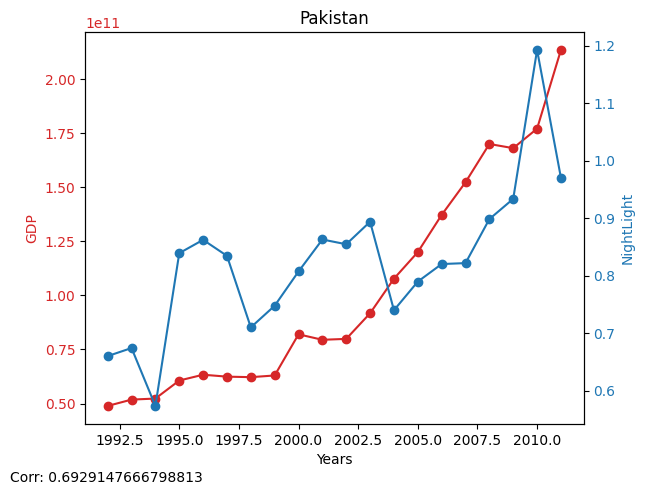

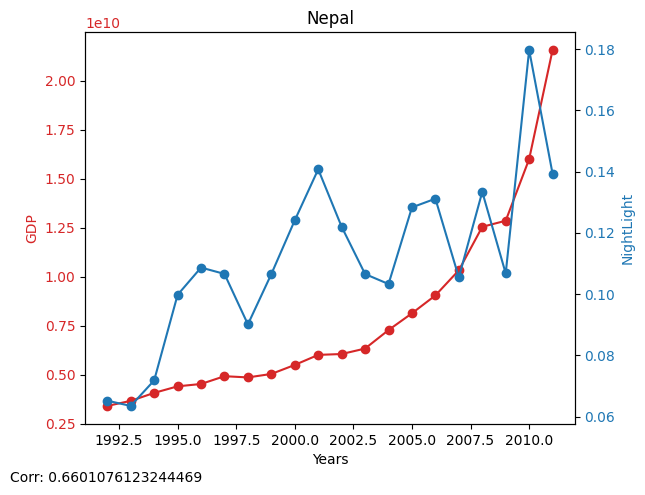

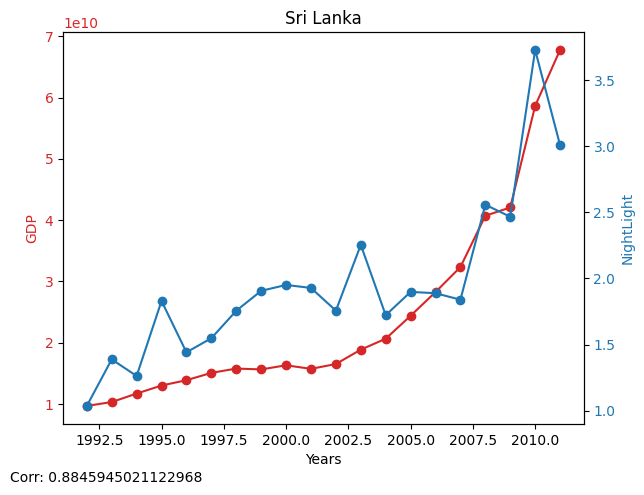

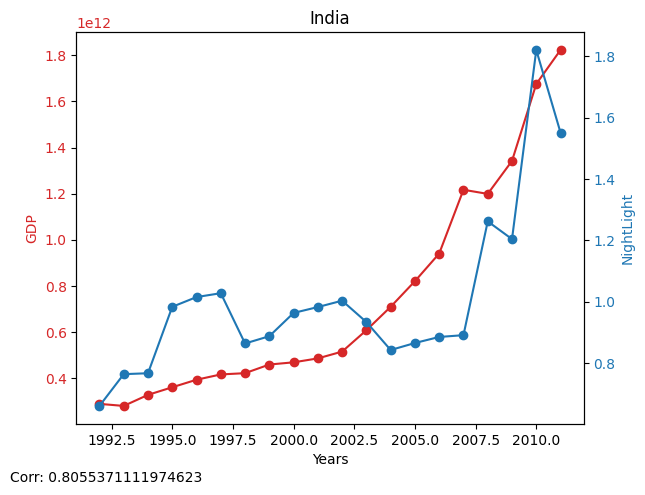

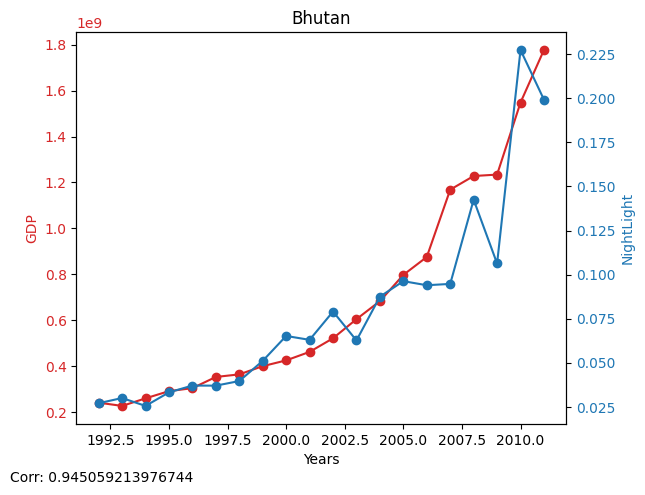

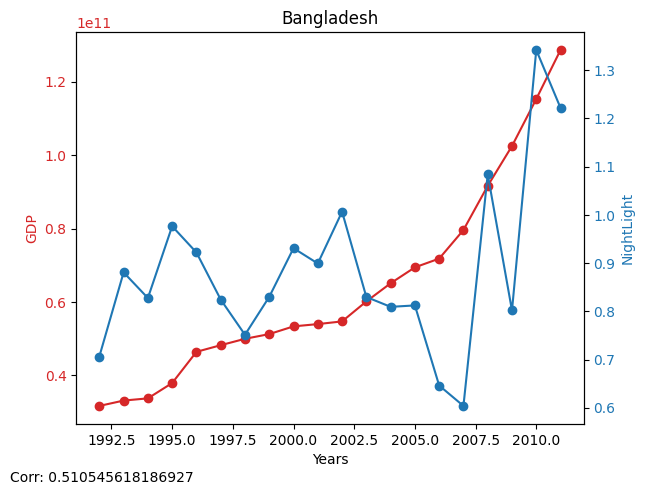

In [40]:

from random import randint
color_int = randint(0, 30)


for country in countries_interested:
    
    filter_ = (gdp_nightlight['Code'] != country) & (gdp_nightlight['Year'] >= year_start) & (gdp_nightlight['Year'] <= year_end)
    gdp_nightlight_filtered = gdp_nightlight.drop(gdp_nightlight[filter_].index, inplace=False)
    # print(gdp_nightlight_filtered.head())
    
#     print(gdp_nightlight_filtered.head(3))
#     print(gdp_nightlight_filtered['Year'].values.astype('datetime64[Y]'))
    
    no_of_test_years = 2
    
    all_gdp = np.array(gdp_nightlight_filtered.GDP.to_list()[0:-1*no_of_test_years])
    all_nightlight = np.array(gdp_nightlight_filtered.NightLight.to_list()[0:-1*no_of_test_years])
    all_years = np.array(gdp_nightlight_filtered.Year.to_list()[0:-1*no_of_test_years])
    
    
    #define x as 200 equally spaced values between the min and max of original x 
    all_years_smooth = np.linspace(all_years.min(), all_years.max(), 200) 
    spl = make_interp_spline(all_years, all_gdp, k=3)
    all_gdp_smooth = spl(all_years_smooth)
     
    spl = make_interp_spline(all_years, all_nightlight, k=3)
    all_nightlight_smooth = spl(all_years_smooth)
    
    # print(gdp_nightlight_filtered.GDP.to_list()[-1*no_of_test_years:])
    
    # pred_gdp = predict(all_nightlight, all_gdp, np.array(gdp_nightlight_filtered.NightLight.to_list()[-1*no_of_test_years:]), np.array(gdp_nightlight_filtered.GDP.to_list()[-1*no_of_test_years:]))
    # print(pred_gdp)

    from matplotlib.dates import YearLocator, DateFormatter
    fig, ax1 = plt.subplots()
    

    color = 'tab:red' #np.random.rand(3,)
    ax1.set_xlabel('Years')
    ax1.set_ylabel('GDP', color=color)
    # ax1.plot(all_years_smooth, all_gdp_smooth, color=color)
    ax1.plot(all_years, all_gdp, color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)
    # ax1.xaxis_date()
    # ax1.xaxis.set_major_formatter(DateFormatter("%Y"))

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('NightLight', color=color)  # we already handled the x-label with ax1
    # ax2.plot(all_years_smooth, all_nightlight_smooth, color=color)
    ax2.plot(all_years, all_nightlight, color=color, marker='o')
    ax2.tick_params(axis='y', labelcolor=color)
    # ax2.xaxis_date()

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    # plt.grid()
    plt.title(gdp_nightlight_filtered.Country.to_list()[0])
    plt.figtext(0.0, 0.0, "Corr: " + str(np.corrcoef(all_nightlight, all_gdp).ravel()[1]))
    plt.show()
    
    # break
    

In [42]:
# Split the data into training and testing sets

all_years = train_years = list(range(year_start, year_end+1))
train_years = list(range(year_start, (year_end - test_for_year)+1))
test_years = list(range((year_end - test_for_year) + 1, year_end+1))

tmp_array = []
for iso, data_list in nightlight_dataset.items():
    if iso == ISO:
        tmp_array = data_list[:-1*(test_for_year)]
        break
train_x = np.array(tmp_array) # training set x

tmp_array = []
for iso, gdp_ in gdp.items():
    if iso == ISO:
        tmp_array = gdp_[:-1*(test_for_year)]
        break
train_y = np.array(tmp_array) # training set y

tmp_array = []
for iso, data_list in nightlight_dataset.items():
    if iso == ISO:
        tmp_array = data_list[-1*(test_for_year):]
test_x = np.array(tmp_array) # test set x

tmp_array = []
for iso, gdp_ in gdp.items():
    if iso == ISO:
        tmp_array = gdp_[-1*(test_for_year):]
        break
test_y = np.array(tmp_array) # training set y

# train_xy = np.vstack((train_x, train_y)).T
# test_xy = np.vstack((test_x, test_y)).T


print("All Years:", len(all_years), [all_years[0], all_years[-1]])
print("Train Years:", len(train_years), [train_years[0], train_years[-1]])
print("Test Years:", len(test_years), [test_years[0], test_years[-1]])
print("--"*15)
print("NTL Train:", len(train_x), [train_x[0], train_x[-1]])
print("GDP Train:", len(train_y), [train_y[0], train_y[-1]])
print("--"*8)
print("NTL Test:", len(test_x), [test_x[0], test_x[-1]])
print("GDP Test:", len(test_y), [test_y[0], test_y[-1]])



AttributeError: 'list' object has no attribute 'items'

In [ ]:
# Train the linear regression model on the training data
model = LinearRegression() #RandomForestRegressor
model2 = RandomForestRegressor()
model.fit(X=train_x.reshape(-1, 1), y=train_y)
model2.fit(X=train_x.reshape(-1, 1), y=train_y)

# Predict the GDP values for the test data
pred_y = model.predict(test_x.reshape(-1, 1)).ravel()
print("Predicted:", len(pred_y), [pred_y[0], pred_y[-1]])
print("Actual:", len(test_y), [test_y[0], test_y[-1]])

# Evaluate the performance of the model
mse = mean_squared_error(test_y, pred_y)
r2 = r2_score(test_y, pred_y)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)

all_x = np.concatenate([train_x, test_x])
all_y = np.concatenate([train_y, test_y])

# Plot the results
fig, ax1 = plt.subplots()
ax1.set_xlabel('Years')
ax1.set_ylabel('GDP')
ax1.plot(all_years, all_y, marker="s", color='red')
ax1.plot(test_years, pred_y, marker="o", color='orange')
ax1.plot(test_years, test_y, marker="^", color='magenta')
ax1.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.grid()
plt.show()


In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Years')
ax1.set_ylabel('GDP', color=color)
ax1.plot(all_years, all_y, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('NightLight', color=color)  # we already handled the x-label with ax1
ax2.plot(all_years, all_x, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.grid()
plt.show()

In [ ]:
import seaborn as sns
from scipy.stats import pearsonr

sns.set(style='white')

g = sns.JointGrid(x=train_x, y=train_y)
g = g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.histplot, kde=False, bins=5, color="xkcd:bluey grey")


In [ ]:
correlation = ps.Series(train_x).corr(ps.Series(train_y))
print("Correlation:", correlation)
plt.plot(train_x, train_y, 'o')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(train_x, train_y, 1)

#add linear regression line to scatterplot 
plt.plot(train_x, m*train_x+b)
plt.show()

In [ ]:
import statsmodels.api as sm
import matplotlib.animation as animation
from sklearn import datasets, linear_model

# !pip install statsmodels


In [ ]:
x = sm.add_constant(train_x).astype(float)

mod = sm.OLS(train_x, train_y)
res_v1= mod.fit()
print(res_v1.summary())


mod = sm.OLS(train_x, train_y)
mod = mod.fit()
x_1 = np.arange(2010,2014,1)
x_2 = np.arange(1992,2014,1)

%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
print(mod.predict(test_y).ravel())
ax.scatter(train_x, train_y, color='red', marker='h')
ax.plot(test_x, test_y, color='blue', marker='^')
ax.scatter(mod.predict(test_y).ravel(), test_y, c="orange")
ax.plot(mod.predict(test_y).ravel(), test_y, c="green")

In [ ]:
import tensorflow as tf


In [ ]:
# Optionally, the first layer can receive an `input_shape` argument:
model = tf.keras.Sequential()
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(train_x, train_y, epochs=500)


In [ ]:
print(predictions)
print(test_y)
print(test_x)

In [ ]:
# Plot the results
fig, ax1 = plt.subplots()
ax1.set_xlabel('Years')
ax1.set_ylabel('GDP')
ax1.plot(train_years, train_y, marker="s", color='red')
ax1.plot(test_years, predictions, marker="o", color='orange')
ax1.plot(test_years, test_y, marker="^", color='magenta')
ax1.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.grid()
plt.show()